In [1]:
from power_grid_model import PowerGridModel, CalculationMethod
from power_grid_model.utils import json_deserialize_from_file
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_triangular

# PGM Source Comparison

In [2]:
def calculate_all_source_sk(start_sk_log, end_sk_log, method: CalculationMethod = CalculationMethod.newton_raphson):
    n_steps = end_sk_log - start_sk_log
    source_p = np.zeros(n_steps, dtype=np.float64)
    node_voltage_pu = np.zeros(n_steps, dtype=np.float64)
    line_p = np.zeros(n_steps, dtype=np.float64)

    input_data = json_deserialize_from_file("grid.json")

    for i, sk_log in enumerate(range(start_sk_log, end_sk_log)):
        sk = float(10 ** sk_log)
        input_data["source"]["sk"] = sk
        model = PowerGridModel(input_data)
        result = model.calculate_power_flow(calculation_method=method)
        source_p[i] = result["source"]["p"][0]
        node_voltage_pu[i] = result["node"]["u_pu"][0]
        line_p[i] = result["line"]["p_from"][0]
    
    return {
        "source_p": source_p, 
        "node_voltage_pu": node_voltage_pu, 
        "line_p": line_p, 
        "sk": np.array([float(10 ** sk_log) for sk_log in range(start_sk_log, end_sk_log)])
    }


In [3]:
pgm_calculation = calculate_all_source_sk(8, 36, CalculationMethod.newton_raphson)

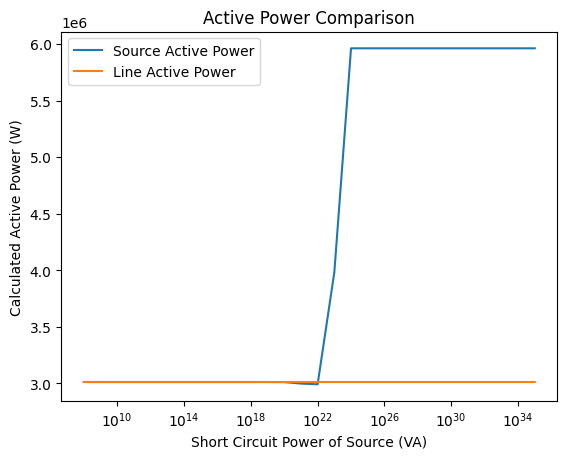

In [4]:
plt.plot(pgm_calculation["sk"], pgm_calculation["source_p"])
plt.plot(pgm_calculation["sk"], pgm_calculation["line_p"])
plt.xscale("log")
_ = plt.xlabel('Short Circuit Power of Source (VA)')
_ = plt.ylabel('Calculated Active Power (W)')
_ = plt.legend(["Source Active Power", "Line Active Power"])
plt.title("Active Power Comparison")
plt.show()

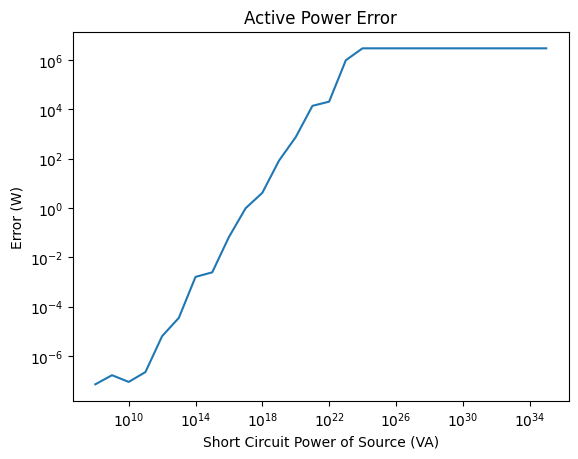

In [5]:
p_error = np.abs(pgm_calculation["source_p"] - pgm_calculation["line_p"])
plt.plot(pgm_calculation["sk"], p_error)
plt.xscale("log")
plt.yscale("log")
_ = plt.xlabel('Short Circuit Power of Source (VA)')
_ = plt.ylabel('Error (W)')
plt.title("Active Power Error")
plt.show()

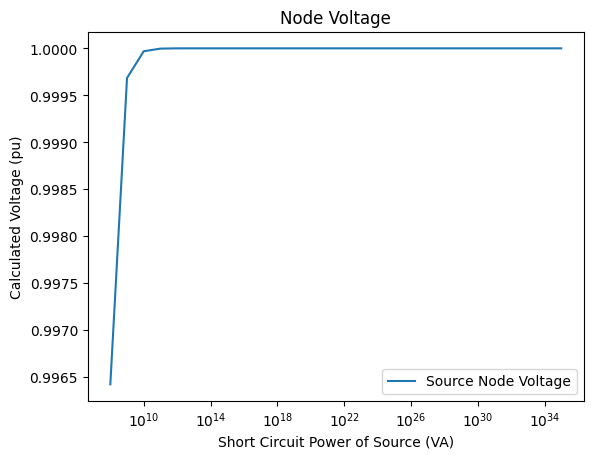

In [6]:
plt.plot(pgm_calculation["sk"], pgm_calculation["node_voltage_pu"])
plt.xscale("log")
_ = plt.xlabel('Short Circuit Power of Source (VA)')
_ = plt.ylabel('Calculated Voltage (pu)')
_ = plt.legend(["Source Node Voltage"])
plt.title("Node Voltage")
plt.show()

# Hand calculation


```
bus_0 ---branch_0(y=100 pu)--- bus_1 ---branch_1(y=200 pu)-- bus_2 ---source(yk=1e50 pu, u= 1.05 pu)
 |                              |
 |                              |
load_gen_0(-2 pu)             load_gen_1(1 pu)
```

## LU factorization function

In [7]:
def lu_factorization(matrix: np.ndarray):
    n = matrix.shape[0]
    assert matrix.shape[1] == n
    u = matrix.copy()                                               
    l = np.eye(n)
    for j in range(n-1):
        lam = np.eye(n)
        gamma = u[j+1:, j] / u[j, j]
        lam[j+1:, j] = -gamma
        u = lam @ u
        
        lam[j+1:, j] = gamma
        l = l @ lam
    return l, u, l - np.eye(n) + u

def forwards_backwards(lu, b):
    y = solve_triangular(lu, b, lower=True, unit_diagonal=True)
    x = solve_triangular(lu, y, lower=False)
    return y, x

## Grid Input

In [8]:
from dataclasses import dataclass

@dataclass
class GridInput:
    ybus: np.ndarray
    load: np.ndarray
    yk: float
    u_ref: float
    slack_bus: int

def get_input():
    return GridInput(
        ybus = np.array([
            [100.0, -100.0, 0.0],
            [-100.0, 300.0, -200.0],
            [0.0, -200.0, 200.0]
        ], dtype=np.float64),
        load = np.array([-2.0, 1.0, 0.0], dtype=np.float64),
        yk = 1e50,
        u_ref = 1.05,
        slack_bus = 2
    )

## Linear PF

In [13]:
def linear_pf(grid_input: GridInput):
    matrix = grid_input.ybus.copy()
    np.fill_diagonal(matrix, matrix.diagonal() - grid_input.load)
    rhs = np.zeros_like(grid_input.load)
    rhs[grid_input.slack_bus] = grid_input.u_ref * grid_input.yk
    matrix[grid_input.slack_bus, grid_input.slack_bus] += grid_input.yk
    l, u, lu = lu_factorization(matrix)
    u_temp, bus_u = forwards_backwards(lu, rhs)
    source_p = (grid_input.u_ref - bus_u[grid_input.slack_bus]) * grid_input.yk * bus_u[grid_input.slack_bus]
    print('----Linear Power FLow-----')
    print('Matrix')
    print(matrix)
    print(f'RHS {rhs}')
    print('LU Matrix')
    print(lu)
    print(f'Forwards Result {u_temp}')
    print(f'Backwards Result: Bus Voltage {bus_u}')
    print(f'Source Active Power: {source_p}')
    print(f'Injection by Y Bus {(grid_input.ybus @ bus_u) * bus_u}')


In [14]:
linear_pf(get_input())

----Linear Power FLow-----
Matrix
[[ 1.02e+02 -1.00e+02  0.00e+00]
 [-1.00e+02  2.99e+02 -2.00e+02]
 [ 0.00e+00 -2.00e+02  1.00e+50]]
RHS [0.00e+00 0.00e+00 1.05e+50]
LU Matrix
[[ 1.02000000e+02 -1.00000000e+02  0.00000000e+00]
 [-9.80392157e-01  2.00960784e+02 -2.00000000e+02]
 [ 0.00000000e+00 -9.95219046e-01  1.00000000e+50]]
Forwards Result [0.00e+00 0.00e+00 1.05e+50]
Backwards Result: Bus Voltage [1.02449019 1.04498    1.05      ]
Source Active Power: 0.0
Injection by Y Bus [-2.09916032  1.0919832   1.05420041]


## Newton-Raphson PF

In [15]:
def newton_raphson_pf(grid_input: GridInput, u_init: np.ndarray, n_iter: int = 5):
    u = u_init.copy()
    for i in range(n_iter):
        print(f'----Newton Raphson Iteration {i}----')
        print(f'Current Voltage {u}')
        i_bus = grid_input.ybus @ u
        p_bus = i_bus * u
        jacobian = np.diag(i_bus) + np.diag(u) @ grid_input.ybus
        delta_p = grid_input.load -  p_bus
        delta_p[grid_input.slack_bus] += u[grid_input.slack_bus] * (grid_input.u_ref - u[grid_input.slack_bus]) * grid_input.yk
        jacobian[grid_input.slack_bus, grid_input.slack_bus] -= (grid_input.u_ref - 2 * u[grid_input.slack_bus]) * grid_input.yk
        _, _, lu = lu_factorization(jacobian)
        delta_temp, delta_u = forwards_backwards(lu, delta_p)
        u += delta_u
        print(f'Jacobian')
        print(jacobian)
        print(f'Delta P {delta_p}')
        print('LU Matrix')
        print(lu)
        print(f'Forwards Result {delta_temp}')
        print(f'Backwards Result: delta U {delta_u}')
        print(f'Updated Voltage {u}')
        print('\n')
        
    source_p = (grid_input.u_ref - u[grid_input.slack_bus]) * grid_input.yk * u[grid_input.slack_bus]
    print('\n----Newton Raphson result-----')
    print(f'Final Voltage {u}')
    print(f'Source Active Power: {source_p}')
    print(f'Injection by Y Bus {(grid_input.ybus @ u) * u}')

In [20]:
newton_raphson_pf(get_input(), u_init=np.random.rand(3) * 0.1 + 1.0, n_iter=5)

----Newton Raphson Iteration 0----
Current Voltage [1.06908132 1.08972438 1.00084441]
Jacobian
[[ 1.04843827e+02 -1.06908132e+02  0.00000000e+00]
 [-1.08972438e+02  3.46757615e+02 -2.17944876e+02]
 [ 0.00000000e+00 -2.00168882e+02  9.51688815e+49]]
Delta P [ 2.06910654e-01 -2.06204590e+01  4.91970996e+48]
LU Matrix
[[ 1.04843827e+02 -1.06908132e+02  0.00000000e+00]
 [-1.03937868e+00  2.35639581e+02 -2.17944876e+02]
 [ 0.00000000e+00 -8.49470537e-01  9.51688815e+49]]
Forwards Result [ 2.06910654e-01 -2.04054005e+01  4.91970996e+48]
Backwards Result: delta U [-0.03757325 -0.03878314  0.05169452]
Updated Voltage [1.03150808 1.05094124 1.05253893]


----Newton Raphson Iteration 1----
Current Voltage [1.03150808 1.05094124 1.05253893]
Jacobian
[[ 1.01207492e+02 -1.03150808e+02  0.00000000e+00]
 [-1.05094124e+02  3.16906148e+02 -2.10188247e+02]
 [ 0.00000000e+00 -2.10507786e+02  1.05507786e+50]]
Delta P [ 4.54598139e-03 -7.06494067e-01 -2.67232374e+47]
LU Matrix
[[ 1.01207492e+02 -1.03150808